# Objective
Forecast sales (no. of items sold) for each item and store for the next 28 days


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Common functions

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int16`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

# Load data

In [3]:
sell_prices = pd.read_csv("./data/sell_prices.csv")
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


File 2: “sell_prices.csv”

Contains information about the price of the products sold per store and date.
* store_id: The id of the store where the product is sold. 
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

In [4]:
calendar = pd.read_csv("./data/calendar.csv")
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


File 1: “calendar.csv” 

Contains information about the dates the products are sold.
* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.


In [5]:
sales_tr_val = pd.read_csv("./data/sales_train_validation.csv")
print("len(sales_tr_val) = " + str(len(sales_tr_val)))
sales_tr_val.head()

len(sales_tr_val) = 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


For each (item_id, store_id), we have the number of items sold for 1913 days or 5.24 years.

There are 30,490 distinct id's, and 1913 days which gives 30,490*1913 = 58,327,370

In [6]:
sample_sub = pd.read_csv("./data/sample_submission.csv")
sample_sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Provide the forecast for each id for the next 28 days. For the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)

Note 30,490*2 = 60,980 which is the number of rows in the submission file.

# Pre-process data

In [7]:
print(calendar.memory_usage().sum())

# # In calendar 'd' column, change 'd_1' to 1
# calendar['d'] = calendar.apply(lambda row: row['d'].split('_')[1], axis=1)

# Replance NaN with nil
calendar = calendar.fillna(value = 'nil')

# Downcast dtypes from 64 bit to save memory
calendar= downcast_dtypes(calendar)

# Change to category dtype
calendar[["year", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] = \
    calendar[["year", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] .astype("category")

# # Convert calendar features to categorical
# columns_to_be_labeled = [
#     'year',
#     'event_name_1',
#     'event_type_1',
#     'event_name_2',
#     'event_type_2'
# ]
# for column in columns_to_be_labeled:
#     calendar.loc[:, column] = LabelEncoder().fit_transform(calendar[column]) # fit_transform: Fit label encoder and return encoded labels. Note the encoded labels are integers!!

# Drop weekday column since its not used
calendar.drop(['weekday'], axis=1, inplace=True)

print(calendar.memory_usage().sum())

calendar.head()

220608
67297


,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,1,1,2011,d_1,nil,nil,nil,nil,0,0,0
1,2011-01-30,11101,2,1,2011,d_2,nil,nil,nil,nil,0,0,0
2,2011-01-31,11101,3,1,2011,d_3,nil,nil,nil,nil,0,0,0
3,2011-02-01,11101,4,2,2011,d_4,nil,nil,nil,nil,1,1,0
4,2011-02-02,11101,5,2,2011,d_5,nil,nil,nil,nil,1,0,1


In [8]:
# # Convert sales_tr_val features to categorical
# columns_to_be_labeled = [
#     'dept_id',
#     'cat_id',
#     'state_id'
# ]
# for column in columns_to_be_labeled:
#     sales_tr_val.loc[:, column] = LabelEncoder().fit_transform(sales_tr_val[column]) # fit_transform: Fit label encoder and return encoded labels. Note the encoded labels are integers!!

# sales_tr_val

In [9]:
# Downcast dtypes from 64 bit to save memory
print(sell_prices.memory_usage().sum())
sell_prices = downcast_dtypes(sell_prices)

sell_prices[["store_id", "item_id"]] = \
    sell_prices[["store_id","item_id"]].astype("category")

print(sell_prices.memory_usage().sum())

218915952
61676881


In [10]:
# Downcast dtypes from 64 bit to save memory
print(sales_tr_val.memory_usage().sum())
sales_tr_val = downcast_dtypes(sales_tr_val)

sales_tr_val[["item_id", "dept_id", "cat_id", "store_id", "state_id"]] = \
    sales_tr_val[["item_id", "dept_id", "cat_id", "store_id", "state_id"]].astype("category")

print(sales_tr_val.memory_usage().sum())

468082560
117188976


In [11]:
# Melt sales_tr_val to switch from a wide to a long dataframe
tic = time.time()
value_vars = ['d_' + str(x) for x in range(1, 1914)]
sale_tr_val_melt = pd.melt(sales_tr_val, 
                           id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                           value_vars=value_vars)

toc = time.time()
print("Time taken = " + str(toc-tic) + ' s')
sale_tr_val_melt

Time taken = 35.82743573188782 s


,id,item_id,dept_id,cat_id,store_id,state_id,variable,value
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [12]:
del sales_tr_val
gc.collect();
sales_tr_val = pd.DataFrame()

In [13]:
# Merge with calendar to get events info
sale_tr_val_melt_merged = sale_tr_val_melt.merge(calendar, 
                                                 left_on='variable', 
                                                 right_on='d', 
                                                 how='left')

# Drop unneccesary columns
sale_tr_val_melt_merged.drop(columns=['d'], inplace=True)

sale_tr_val_melt_merged.head()

,id,item_id,dept_id,cat_id,store_id,state_id,variable,value,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0


In [14]:
del calendar
gc.collect();
calendar = pd.DataFrame()

del sale_tr_val_melt
gc.collect();
sale_tr_val_melt = pd.DataFrame()

In [15]:
# Merge with sell_prices to get price info
sale_tr_val_melt_merged2 = sale_tr_val_melt_merged.merge(sell_prices, 
                                                         left_on=['store_id', 'item_id', 'wm_yr_wk'], 
                                                         right_on=['store_id', 'item_id', 'wm_yr_wk'], 
                                                         how='left')
sale_tr_val_melt_merged2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,variable,value,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN


In [16]:
del sell_prices
gc.collect();
sell_prices = pd.DataFrame()

del sale_tr_val_melt_merged
gc.collect();
sale_tr_val_melt_merged = pd.DataFrame()

In [17]:
# # Convert remaining features to categorical
# columns_to_be_labeled = [
#     'wm_yr_wk',
#     'item_id',
#     'store_id',
# ]
# for column in columns_to_be_labeled:
#     sale_tr_val_melt_merged2.loc[:, column] = LabelEncoder().fit_transform(sale_tr_val_melt_merged2[column]) # fit_transform: Fit label encoder and return encoded labels. Note the encoded labels are integers!!
# sale_tr_val_melt_merged2.head()    


In [18]:
# Get no. of distinct values in each column
print("item_id uniques = " + str(sale_tr_val_melt_merged2['item_id'].nunique()))
print("dept_id uniques = " + str(sale_tr_val_melt_merged2['dept_id'].nunique()))
print("cat_id uniques = " + str(sale_tr_val_melt_merged2['cat_id'].nunique()))
print("store_id uniques = " + str(sale_tr_val_melt_merged2['store_id'].nunique()))
print("state_id uniques = " + str(sale_tr_val_melt_merged2['state_id'].nunique()))

item_id uniques = 3049
dept_id uniques = 7
cat_id uniques = 3
store_id uniques = 10
state_id uniques = 3


In [19]:
print(sale_tr_val_melt_merged2['dept_id'].unique())

[HOBBIES_1, HOBBIES_2, HOUSEHOLD_1, HOUSEHOLD_2, FOODS_1, FOODS_2, FOODS_3]
Categories (7, object): [HOBBIES_1, HOBBIES_2, HOUSEHOLD_1, HOUSEHOLD_2, FOODS_1, FOODS_2, FOODS_3]


In [20]:
print(sale_tr_val_melt_merged2['cat_id'].unique())

[HOBBIES, HOUSEHOLD, FOODS]
Categories (3, object): [HOBBIES, HOUSEHOLD, FOODS]


In [21]:
print(sale_tr_val_melt_merged2['store_id'].unique())

[CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3]
Categories (10, object): [CA_1, CA_2, CA_3, CA_4, ..., TX_3, WI_1, WI_2, WI_3]


In [22]:
print(sale_tr_val_melt_merged2['state_id'].unique())

[CA, TX, WI]
Categories (3, object): [CA, TX, WI]


# EDA

In [23]:
sale_tr_val_melt_merged2['sell_price'].describe()

count    4.602796e+07
mean     3.341988e+00
std      3.368911e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64

Prices range from 0.01 to 107.32

In [24]:
# Count number of nulls for each column
sale_tr_val_melt_merged2.isnull().sum(axis=0)

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
variable               0
value                  0
date                   0
wm_yr_wk               0
wday                   0
month                  0
year                   0
event_name_1           0
event_type_1           0
event_name_2           0
event_type_2           0
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64

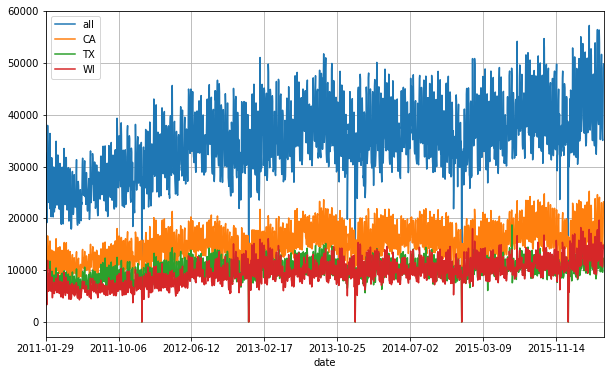

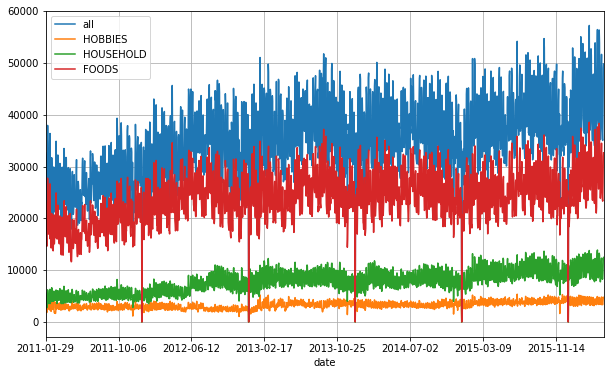

In [25]:
# Plot number of items sold across the days for all shops
ax = sale_tr_val_melt_merged2.groupby("date").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='CA'].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='TX'].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='WI'].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])

# Plot number of items sold across the days for all shops
ax = sale_tr_val_melt_merged2.groupby("date").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOBBIES'].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOUSEHOLD'].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='FOODS'].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'HOBBIES', 'HOUSEHOLD', 'FOODS'])

- On Christmas days, the no. of items sold are close to 0
- Number of items sold increases over time for all 3 states
- CA has the highest no. of items sold across all periods
- At any time, FOODS have highest number of items sold, followed by HOUSEHOLD AND HOBBIES

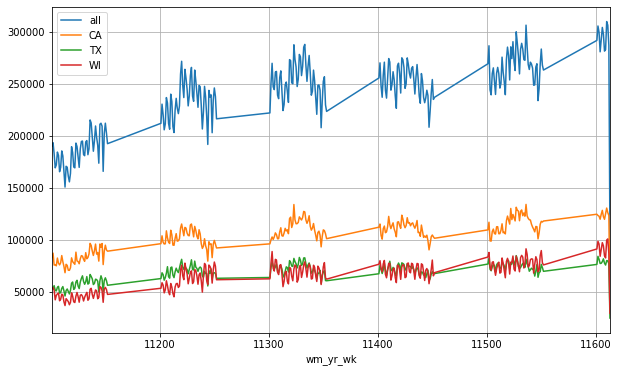

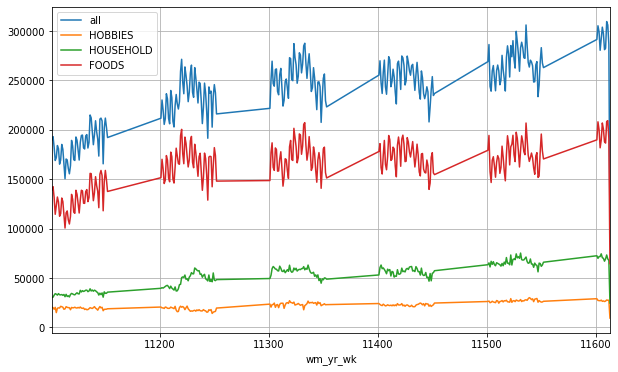

In [26]:
# Plot number of items sold across the week ids for all shops
ax = sale_tr_val_melt_merged2.groupby("wm_yr_wk").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='CA'].groupby("wm_yr_wk") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='TX'].groupby("wm_yr_wk") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='WI'].groupby("wm_yr_wk") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])

# Plot number of items sold across the week ids for all shops
ax = sale_tr_val_melt_merged2.groupby("wm_yr_wk").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOBBIES'].groupby("wm_yr_wk") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOUSEHOLD'].groupby("wm_yr_wk") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='FOODS'].groupby("wm_yr_wk") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'HOBBIES', 'HOUSEHOLD', 'FOODS'])

There is a general upward trend over time, most noticeable for FOODS, and HOUSEHOLD, less so for HOBBIES

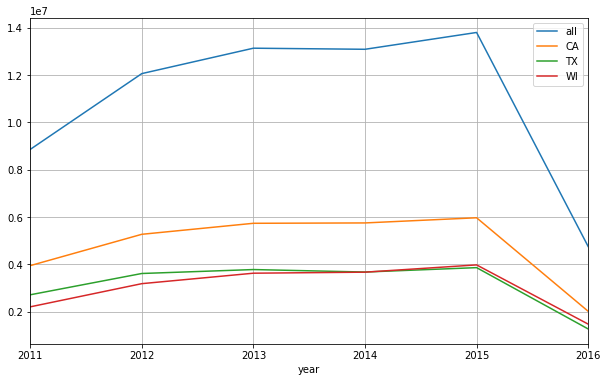

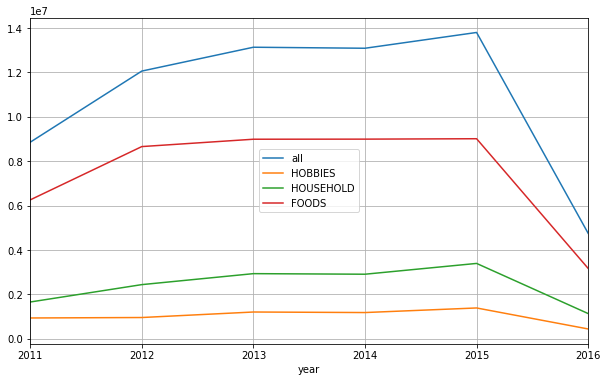

In [28]:
# Plot number of items sold across the year for all shops
ax = sale_tr_val_melt_merged2.groupby("year").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='CA'].groupby("year") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='TX'].groupby("year") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='WI'].groupby("year") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])

# Plot number of items sold across the year for all shops
ax = sale_tr_val_melt_merged2.groupby("year").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOBBIES'].groupby("year") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOUSEHOLD'].groupby("year") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='FOODS'].groupby("year") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'HOBBIES', 'HOUSEHOLD', 'FOODS'])

There is a general upward trend across the years, less so for HOBBIES

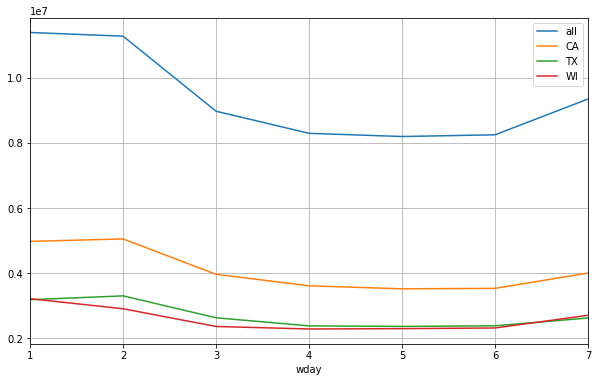

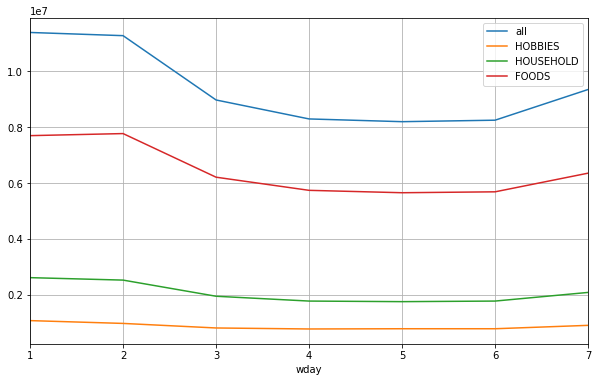

In [29]:
# Plot number of items sold across the weekdays for all shops
ax = sale_tr_val_melt_merged2.groupby("wday").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='CA'].groupby("wday") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='TX'].groupby("wday") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='WI'].groupby("wday") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])

# Plot number of items sold across the weekdays for all shops
ax = sale_tr_val_melt_merged2.groupby("wday").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOBBIES'].groupby("wday") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOUSEHOLD'].groupby("wday") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='FOODS'].groupby("wday") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'HOBBIES', 'HOUSEHOLD', 'FOODS'])

- More items are sold on Sat, Sun, then a decline in the weekdays, and the items sold increase again on Fri
- This decline is not very significant for HOBBIES

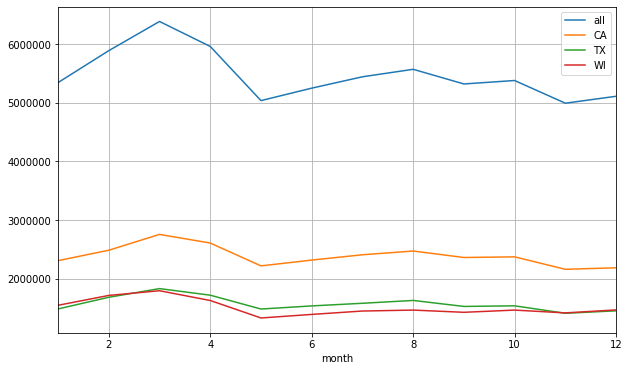

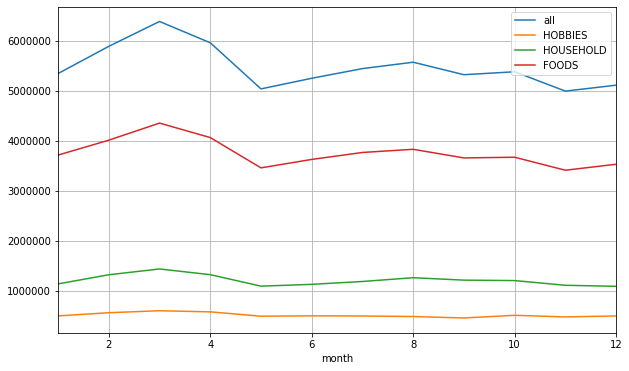

In [30]:
# Plot avg price of items sold across the calendar months for all shops
ax = sale_tr_val_melt_merged2.groupby("month").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='CA'].groupby("month") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='TX'].groupby("month") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='WI'].groupby("month") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])

ax = sale_tr_val_melt_merged2.groupby("month").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOBBIES'].groupby("month") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOUSEHOLD'].groupby("month") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='FOODS'].groupby("month") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'HOBBIES', 'HOUSEHOLD', 'FOODS'])

- The highest number of items sold are in Feb, Mar and Apr
- This trend is not very significant for HOBBIES

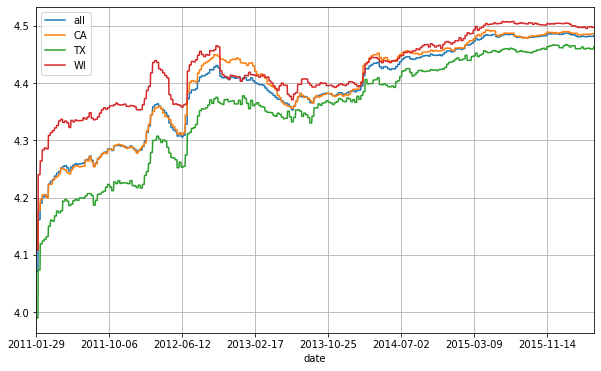

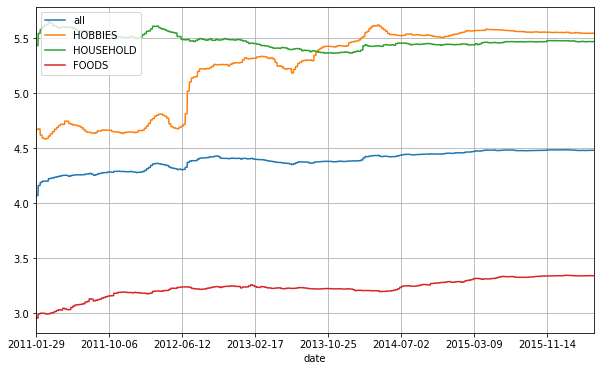

In [31]:
# Plot avg price of items sold across the days for all shops
ax = sale_tr_val_melt_merged2.groupby("date").agg({"sell_price": "mean"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='CA'].groupby("date") \
                                                                         .agg({"sell_price": "mean"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='TX'].groupby("date") \
                                                                         .agg({"sell_price": "mean"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['state_id']=='WI'].groupby("date") \
                                                                         .agg({"sell_price": "mean"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])

# Plot avg price of items sold across the days for all shops
ax = sale_tr_val_melt_merged2.groupby("date").agg({"sell_price": "mean"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOBBIES'].groupby("date") \
                                                                         .agg({"sell_price": "mean"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='HOUSEHOLD'].groupby("date") \
                                                                         .agg({"sell_price": "mean"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['cat_id']=='FOODS'].groupby("date") \
                                                                         .agg({"sell_price": "mean"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'HOBBIES', 'HOUSEHOLD', 'FOODS'])

- Avg price of items increased over time in the 5 years
- Avg price of items are highest in WI, followed by CA, then TX
- Around 2011 to 2013, avg price of items are highest for HOUSEHOLD, then HOBBIES, and FOODS

In [32]:
sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['date']=='2015-01-01']

,id,item_id,dept_id,cat_id,store_id,state_id,variable,value,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
43692170,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,8.260000
43692171,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,3.970000
43692172,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,2.970000
43692173,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,2,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,4.640000
43692174,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,3,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,2.880000
43692175,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,1.000000
43692176,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,7.880000
43692177,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,0.460000
43692178,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,2,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,1.770000
43692179,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,d_1434,0,2015-01-01,11448,...,1,2015,NewYear,National,nil,nil,1,1,0,2.970000


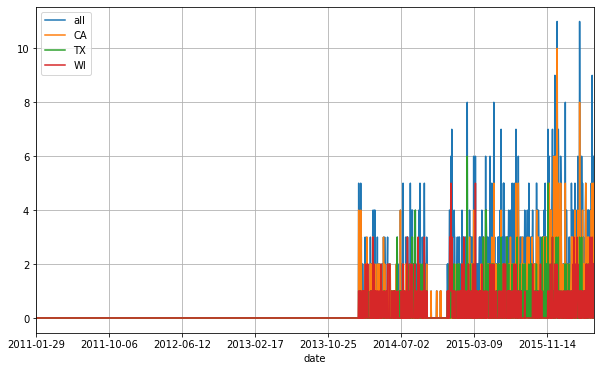

In [33]:
# Plot number of items sold across the days for all shops, for a particular item
item_id = 'HOBBIES_1_003'
ax = sale_tr_val_melt_merged2[sale_tr_val_melt_merged2['item_id']==item_id].groupby("date").agg({"value": "sum"}).plot(figsize=(10, 6))
ax = sale_tr_val_melt_merged2[(sale_tr_val_melt_merged2['item_id']==item_id) & (sale_tr_val_melt_merged2['state_id']=='CA')].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[(sale_tr_val_melt_merged2['item_id']==item_id) & (sale_tr_val_melt_merged2['state_id']=='TX')].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax)
ax = sale_tr_val_melt_merged2[(sale_tr_val_melt_merged2['item_id']==item_id) & (sale_tr_val_melt_merged2['state_id']=='WI')].groupby("date") \
                                                                         .agg({"value": "sum"}) \
                                                                         .plot(figsize=(10, 6), ax=ax, grid=True)
ax.legend(['all', 'CA', 'TX', 'WI'])
